In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
#from sklearn.metrics import confusion_matrix
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
import math
from sklearn.metrics import confusion_matrix
import csv
from sklearn import feature_selection
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline 

## Building features

In [2]:
# Listing columns of the csv
filename = "0_merged_data.csv"
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = reader.next()
zip(header, range(len(header)))

[('', 0),
 ('PERIOD', 1),
 ('PARK', 2),
 ('BOROUGH', 3),
 ('SIZE (ACRES)', 4),
 ('CATEGORY', 5),
 ('MURDER', 6),
 ('RAPE', 7),
 ('ROBBERY', 8),
 ('FELONY ASSAULT', 9),
 ('BURGLARY', 10),
 ('GRAND LARCENY', 11),
 ('GRAND LARCENY OF MOTOR VEHICLE', 12),
 ('CRIME_TOT', 13),
 ('Street_light', 14),
 ('Drinking', 15),
 ('Drugs', 16),
 ('311_Total', 17),
 ('household', 18),
 ('median_income', 19),
 ('average_score', 20),
 ('public_house', 21),
 ('business', 22)]

In [3]:
# Extracting locations of the columns we want
wanted_columns = ['SIZE (ACRES)', 'median_income', 'average_score', 'public_house', 'household', 'business',
                  'Street_light', 'Drinking', 'Drugs',  'CRIME_TOT']
indices = map(lambda x: header.index(x), wanted_columns)
indices

[4, 19, 20, 21, 18, 22, 14, 15, 16, 13]

In [4]:
# Function to fill out NA = '' with zeros and turning string to float for X and Y
def fillna(char):
    if char == '':
        return 0.0
    return float(char)

# Loading the data
filename = "0_merged_data.csv"
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    data = map(lambda feature: map(lambda ind: fillna(feature[ind]), indices), reader)

In [5]:
data[0:2]

[[718.373, 34453.0, 0.625, 0.0, 1069.0, 0.0, 17.0, 1.0, 0.0, 3.0],
 [718.373, 34453.0, 0.625, 0.0, 1069.0, 0.0, 20.0, 0.0, 0.0, 1.0]]

In [6]:
# Building predictors and predicted value
X = map(lambda x: x[:-1], data)
Y = map(lambda y: y[ -1], data)

## Binarizing the target

In [7]:
# Checking the distribution of the target in order to identify classes
itemfreq(Y)

array([[  0.00000000e+00,   3.87500000e+03],
       [  1.00000000e+00,   3.26000000e+02],
       [  2.00000000e+00,   5.10000000e+01],
       [  3.00000000e+00,   1.40000000e+01],
       [  4.00000000e+00,   6.00000000e+00],
       [  5.00000000e+00,   9.00000000e+00],
       [  6.00000000e+00,   6.00000000e+00],
       [  7.00000000e+00,   2.00000000e+00],
       [  8.00000000e+00,   2.00000000e+00],
       [  1.20000000e+01,   1.00000000e+00],
       [  1.70000000e+01,   1.00000000e+00]])

In [8]:
# Turning the predictor into two classes 0 and 1 - has crimes, doesn't have crimes. Whatever is > 0 has crimes
def binarizer(value):
    if value > 0:
        return 1
    return 0
Y = map(lambda y: binarizer(y), Y)

In [9]:
itemfreq(Y)

array([[   0, 3875],
       [   1,  418]])

## LASSO Regression

In [10]:
# Splitting the data into training and testing subsets 90 to 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 908)

# Splitting the training subset into training and validating subsets 90 to 10%
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 908)

In [11]:
print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

3476 3476
387 387
430 430


In [12]:
def trainpredict_L(alpha):
    lassoreg = Lasso(alpha = alpha, normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    Y_predict = np.round(lassoreg.predict(X_valid))
    return (Y_valid == Y_predict).sum()*100/len(Y_valid), alpha

# Function to fit alpha for LASSO
def fitalpha():
    return map(lambda alpha: trainpredict_L(alpha), np.linspace(0, 50, 1000))

# Fitting the alpha
fitted = fitalpha()

In [13]:
# Looking for the optimal parameters
max(enumerate(fitted), key = lambda x: x[1])

(999, (90, 50.0))

In [14]:
# Checkng on the test set
lassoreg = Lasso(alpha = 50, normalize = False, max_iter = 1e5)
lassoreg.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==np.round(lassoreg.predict(X_train))).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==np.round(lassoreg.predict(X_test))).sum()*100/len(Y_test))

We successfully predict the 90 percent of training data
We successfully predict the 90 percent of test data


## SVM

In [15]:
# Fitting the parameter C for the SVM model on the training / validation
# Function to train SVM on training set and to predict the validation set
def trainpredict(degree, C):
    clf = svm.SVC(kernel = 'poly', degree = degree, C = C, max_iter=100000) 
    clf.fit(X_train, Y_train)
    return (Y_valid == clf.predict(X_valid)).sum()*100/len(Y_valid), degree, C

# Function to fit poly SVMs of degrees 1 to 4 each with Cs from the list
def fitDegree_C():
    return map(lambda degree: map(trainpredict, [degree]*len(np.linspace(-10, 2*degree, 200)),
                            map(lambda c: math.exp(c), np.linspace(-10, 2*degree, 200))), range(1, 5)) 
# Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
fitted = fitDegree_C()

In [16]:
# Finding the best fit
flatten = sum(fitted, [])
# Looking for the optimal parameters
max(enumerate(flatten), key = lambda x: x[1])

(175, (89, 1, 1.7380500416548585))

In [17]:
# Checkng on the test set
clf = svm.SVC(kernel = 'poly', degree = 1, C=1.7380500416548585, max_iter=100000)
clf.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==clf.predict(X_train)).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==clf.predict(X_test)).sum()*100/len(Y_test))

We successfully predict the 87 percent of training data
We successfully predict the 86 percent of test data


In [18]:
def plotter(degree, title):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("log(C)")
    ax.set_ylabel("Accuracy")
    ax.set_title(title+" accuracy vs log(C) for degree of "+ str(degree + 1))
    ax.semilogx()
    plot_ = plt.plot(map(lambda x: x[2], fitted[degree]), map(lambda x: x[0], fitted[degree]))
    return True

In [19]:
# Calculate and print out the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[374  16]
 [ 40   0]]


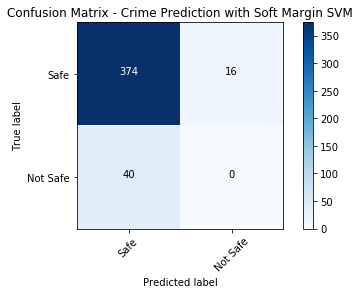

In [20]:
# Confusion matrix
Y_test
Y_predict = clf.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['Safe', 'Not Safe'], normalize=False,
                      title='Confusion Matrix - Crime Prediction with Soft Margin SVM')

Normalized confusion matrix
[[ 0.95897436  0.04102564]
 [ 1.          0.        ]]


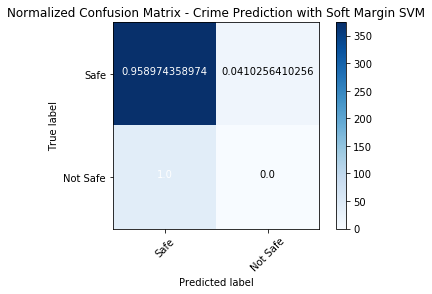

In [21]:
# Confusion matrix
Y_test
Y_predict = clf.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['Safe', 'Not Safe'], normalize=True,
                      title='Normalized Confusion Matrix - Crime Prediction with Soft Margin SVM')

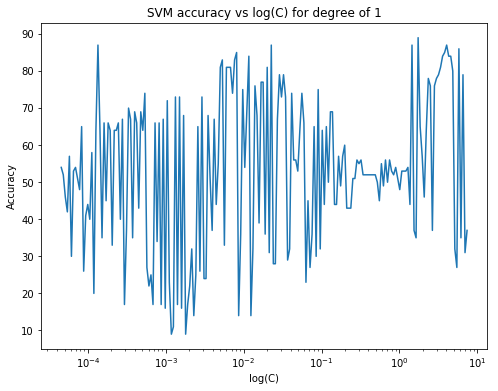

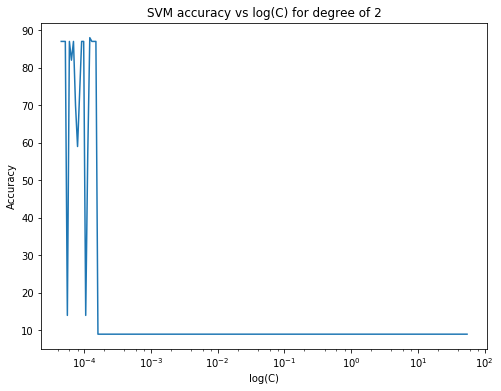

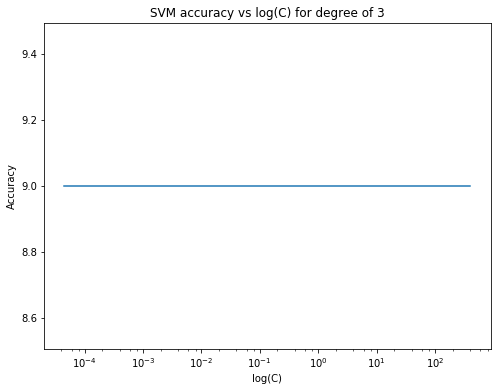

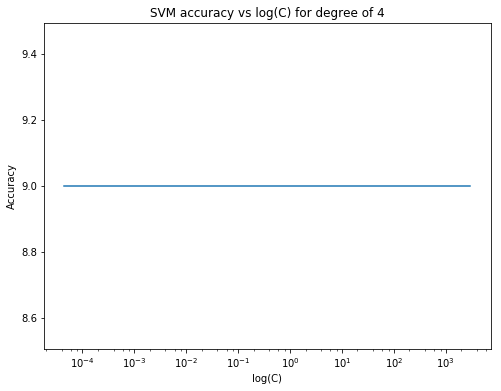

In [22]:
outputs = map(plotter, range(0, 4), ["SVM"]*4)